In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from utils import make_nice_plots
make_nice_plots()


In [2]:
hdul = fits.open('/home/lucas/Documents/PhD/dr16q_prop_May01_2024.fits.gz')
hdul.info()


Filename: /home/lucas/Documents/PhD/dr16q_prop_May01_2024.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    238   750414R x 115C   [18A, K, K, K, D, D, 20A, 10A, D, 12A, D, D, D, D, D, 5D, 5D, 2D, 3D, 3D, D, D, 3D, 3D, D, D, D, D, D, D, D, D, D, D, D, D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 6D, 2D, 2D, 2D, 2D, 2D, 2D, 2D, 2D, 2D, 2D, D, D, D, D, D, D, D, D, D, D, D, D, 8D, 8D, D]   
  2                1 BinTableHDU    188   750414R x 90C   [5D, 5D, 5D, E, D, D, D, D, D, D, D, D, J, J, J, 5E, 5D, 5E, 5D, 5E, D, D, I, D, D, D, D, I, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, I, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, 21A, D, D, E, E, D, K, D, D, E, E, E, E, E, E,

In [3]:
hdr1 = hdul[1].header
hdr2 = hdul[2].header

print(hdr1.keys)
print(hdr2.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3436 / length of dimension 1                          
NAXIS2  =               750414 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  115 / number of table fields                         
TTYPE1  = 'SDSS_NAME'                                                           
TFORM1  = '18A     '                                                            
TTYPE2  = 'PLATE   '                                                            
TFORM2  = 'K       '                                                            

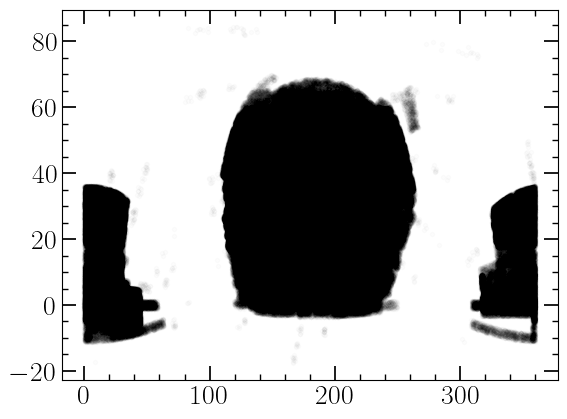

In [4]:
ra_sdss = hdul[1].data['RA']
dec_sdss = hdul[1].data['DEC']

plt.scatter(ra_sdss, dec_sdss, marker='.', alpha=0.01, color='black')
plt.show()


3089


/tmp/ipykernel_8836/1914782322.py:4: RuntimeWarning: divide by zero encountered in divide
  mask = (z_sys > 0) & (z_sys_err > 0) & (z_sys_err < 0.02) & (z_sys_err / z_sys < 0.01)


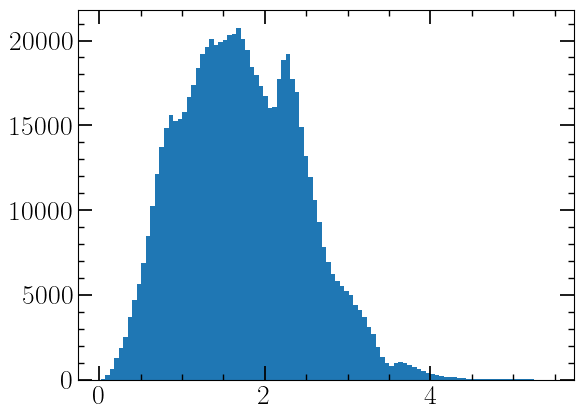

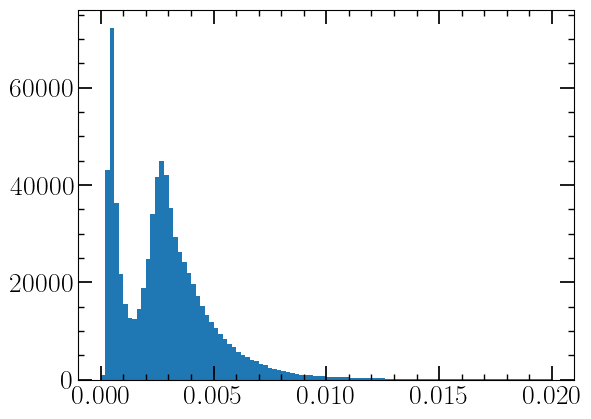

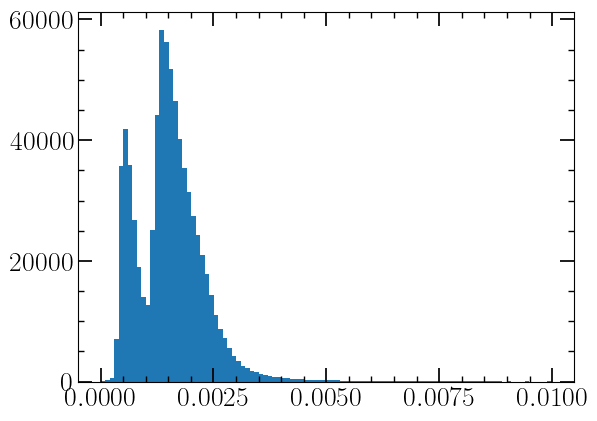

In [5]:
z_sys = hdul[1].data['Z_SYS']
z_sys_err = hdul[1].data['Z_SYS_ERR']

mask = (z_sys > 0) & (z_sys_err > 0) & (z_sys_err < 0.02) & (z_sys_err / z_sys < 0.01)
print(np.sum(~mask))

plt.hist(z_sys[mask], bins=100)
plt.show()

plt.hist(z_sys_err[mask], bins=100)
plt.show()

plt.hist(z_sys_err[mask] / z_sys[mask], bins=100)
plt.show()


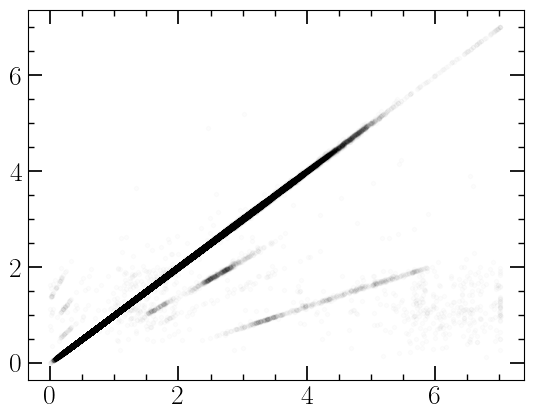

24938


In [6]:
z_sdss = hdul[1].data['Z_DR16Q']
mask = (z_sdss > 0) & (z_sys > 0)
plt.scatter(z_sdss[mask], z_sys[mask], marker = '.', color='black', alpha=0.01)
plt.show()

nonzero_diff = abs(z_sdss[mask] - z_sys[mask]) > 0.01
print(np.sum(nonzero_diff))
# plt.hist(z_sdss[mask][nonzero_diff] - z_sys[mask][nonzero_diff], bins=100)
# plt.show()



In [7]:
QUAIA_PATH = "/home/lucas/Documents/PhD/Quaia_z15.csv"
df = pd.read_csv(QUAIA_PATH)
cols = ["redshift_quaia", "redshift_quaia_err", "ra", "dec", "b", "loglbol_corr"]
quaia = df[cols]

z_quaia = quaia['redshift_quaia']
z_err_quaia = quaia['redshift_quaia_err']
ra_quaia = quaia['ra'].to_numpy()
dec_quaia = quaia['dec'].to_numpy()


136371
0.8150883852723092


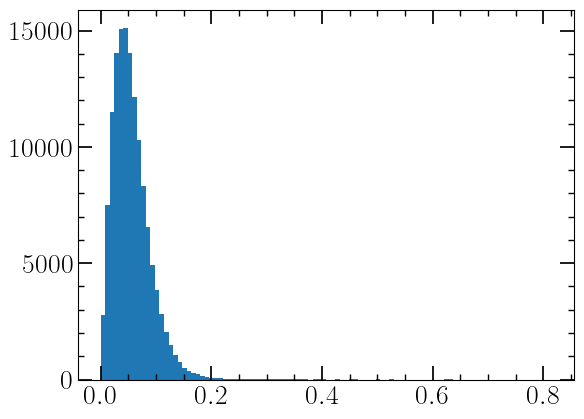

In [8]:
# Make angular crossmatch between SDSS and Quaia

sdss_skycoord = SkyCoord(ra=ra_sdss * u.degree, dec=dec_sdss * u.degree)
quaia_skycoord = SkyCoord(ra=ra_quaia *  u.degree, dec=dec_quaia * u.degree)

max_sep = 1.0 * u.arcsec

idx_sdss, idx_quaia, d2d, _ = quaia_skycoord.search_around_sky(sdss_skycoord, max_sep)
sep_constraint = d2d < max_sep
print(np.sum(sep_constraint))
print(np.max(d2d.to(u.arcsec).value))

plt.hist(d2d[sep_constraint].to(u.arcsec).value, bins=100)
plt.show()


In [9]:
# Get crossmatch of catalogs as new catalogs

sdss_match = hdul[1].data[idx_sdss]
quaia_match = quaia.iloc[idx_quaia]
print(len(sdss_match), len(quaia_match))


136371 136371


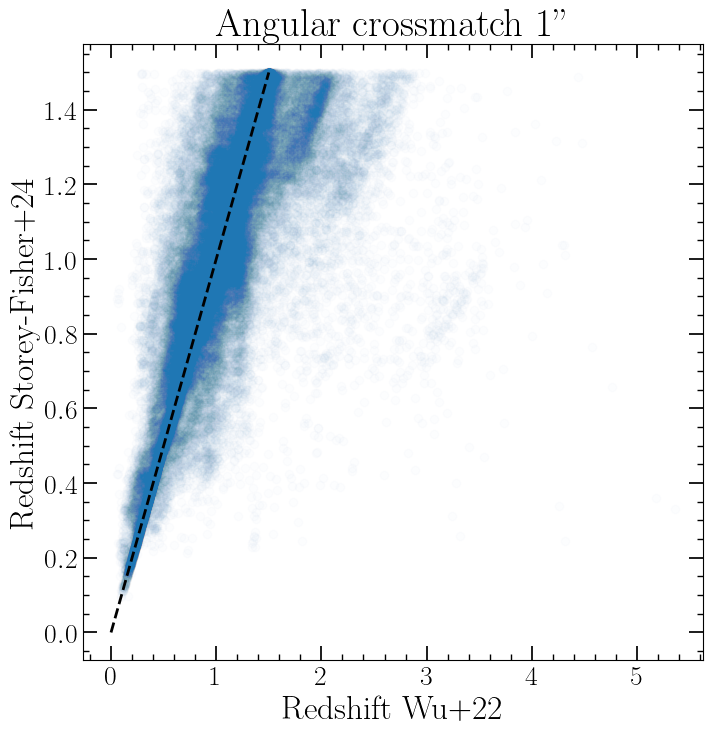

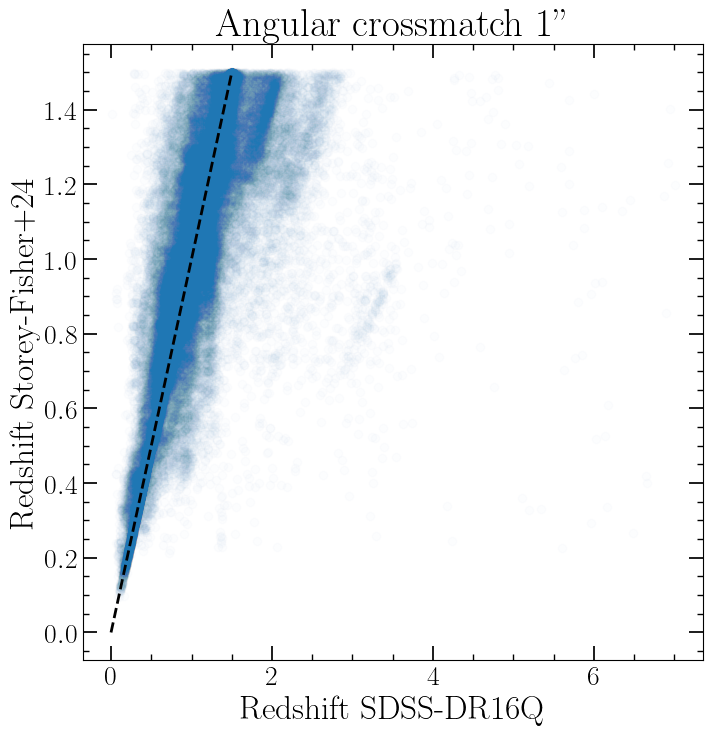

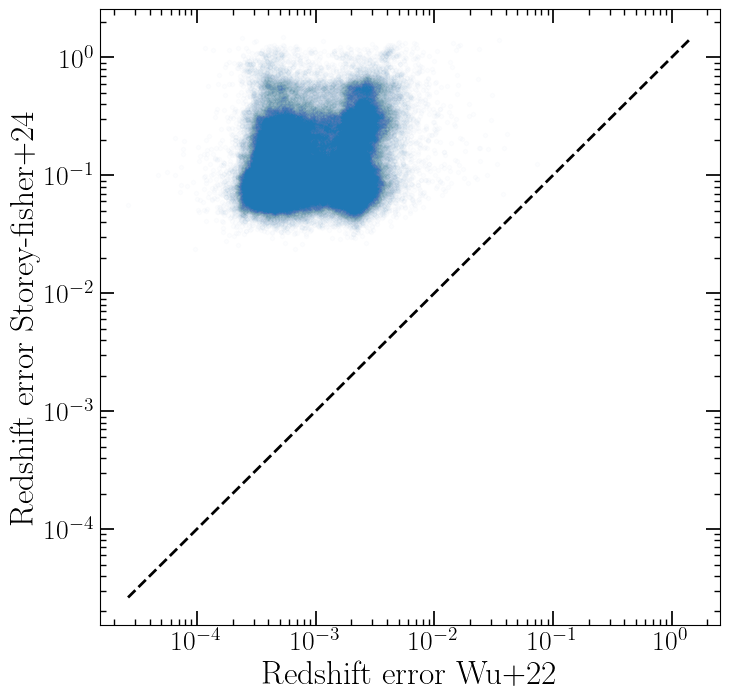

In [10]:
for ztype, label in zip(['Z_SYS', 'Z_DR16Q'], ['Wu+22', 'SDSS-DR16Q']):
    z_sys_match = sdss_match[ztype]
    z_sys_err_match = sdss_match['Z_SYS_ERR']

    z_quaia_match = quaia_match['redshift_quaia'].to_numpy()
    z_err_quaia_match = quaia_match['redshift_quaia_err'].to_numpy()

    mask = (z_sys_match > 0) & (z_sys_err_match > 0)

    zz = np.linspace(0, 1.5, 100)
    plt.figure(figsize=(8, 8))
    plt.scatter(z_sys_match[mask], z_quaia_match[mask], alpha=0.01)
    plt.plot(zz, zz, color='black', linewidth=2, linestyle='dashed')
    plt.xlabel(f'Redshift {label}')
    plt.ylabel('Redshift Storey-Fisher+24')
    plt.title('Angular crossmatch 1"')
    plt.show()


mask = (sdss_match['Z_SYS'] > 0) & (z_sys_err_match > 0)

ss = np.linspace(np.min(z_sys_err_match[mask]), np.max(z_err_quaia_match[mask]), 100)
plt.figure(figsize=(8, 8))
plt.scatter(z_sys_err_match[mask], z_err_quaia_match[mask], marker='.', alpha=0.01)
plt.plot(ss, ss, color='black', linewidth=2, linestyle='dashed')
plt.loglog()
plt.xlabel('Redshift error Wu+22')
plt.ylabel('Redshift error Storey-fisher+24')
plt.show()


80
Mean: -0.0001623769655711757, Standard deviation: 0.21110559223264097


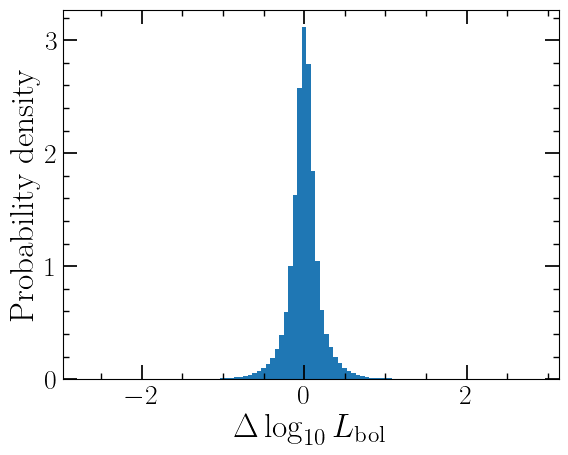

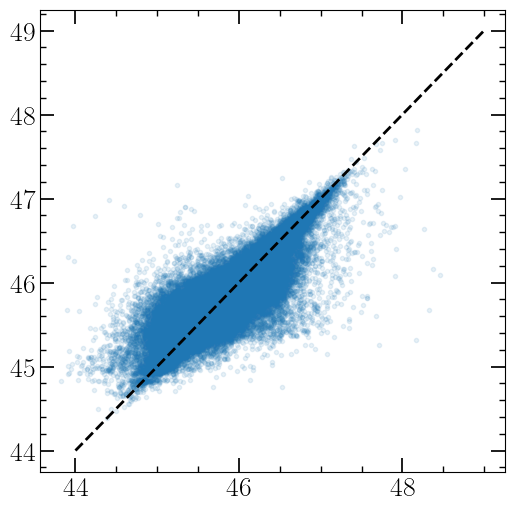

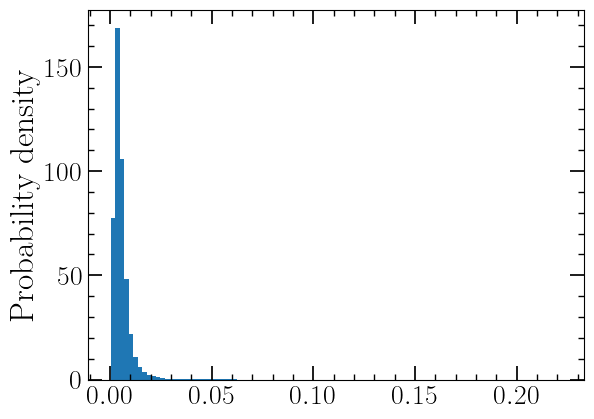

In [14]:
logLbol_sdss = sdss_match['LOGLBOL']
logLbol_err_sdss = sdss_match['LOGLBOL_ERR']
logLbol_quaia = quaia_match['loglbol_corr'].to_numpy()

mask = (logLbol_sdss > 0.) & (logLbol_err_sdss > 0.)
diff = (logLbol_sdss - logLbol_quaia)[mask]
print(np.sum(~mask))
print(f'Mean: {np.mean(diff)}, Standard deviation: {np.std(diff)}')

plt.figure()
plt.hist(diff, bins=100, density=True)
plt.xlabel(r'$\Delta \log_{10} L_{\rm bol}$')
plt.ylabel('Probability density')
plt.show()

ll = np.linspace(44, 49, 100)
plt.figure(figsize=(6,6))
plt.scatter(logLbol_sdss[mask], logLbol_quaia[mask], marker='.', alpha=0.1)
plt.plot(ll, ll, color='black', linestyle='dashed', linewidth=2)
plt.show()

plt.figure()
plt.hist(logLbol_err_sdss[mask], bins=100, density=True)
# plt.xlabel(r'$\Delta \log_{10} L_{\rm bol}$')
plt.ylabel('Probability density')
plt.show()


14.77
15.00
15.35


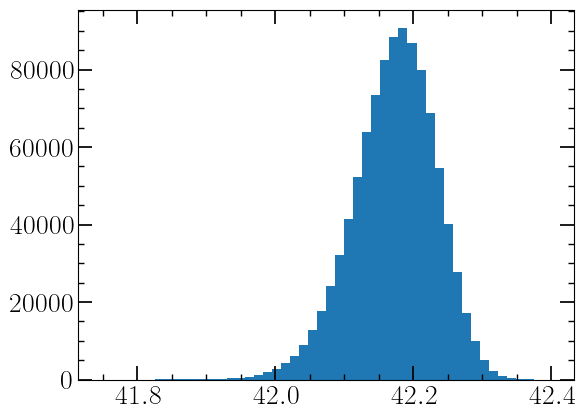

0.05924682493463374


In [208]:
print(f'{np.log10((5100 * u.angstrom).to(u.Hz, equivalencies=u.spectral()).value):.2f}')
print(f'{np.log10((3000 * u.angstrom).to(u.Hz, equivalencies=u.spectral()).value):.2f}')
print(f'{np.log10((1350 * u.angstrom).to(u.Hz, equivalencies=u.spectral()).value):.2f}')

N = int(1e6)
lbolcorr = 1.5
lbolcorr_err = 0.2
bolcorrs = np.random.normal(lbolcorr, lbolcorr_err, size=N)
bolcorrs = bolcorrs[bolcorrs > 0]

log10_l_center = 42
plt.figure()
plt.hist(np.log10(10**log10_l_center * bolcorrs), bins=50)
plt.show()

print(np.std(np.log10(10**log10_l_center * bolcorrs)))
